In [33]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

In [34]:
dog = plt.imread('data')
cat = plt.imread('data')

In [35]:
dog.shape, cat.shape

((1536, 1536, 4), (2157, 1051, 4))

In [36]:
dog = Image.open('data').resize((40, 40))
cat = Image.open('data').resize((21, 40))

DOG_H, DOG_W, DOG_C = np.array(dog).shape
CAT_H, CAT_W, CAT_C = np.array(cat).shape
AN_DIM = 200

In [37]:
pet_data = [[dog, DOG_H, DOG_W, DOG_C], [cat, CAT_H, CAT_W, CAT_C]]
classnames = ['dog', 'cat']

In [38]:
def custom_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # Location
    cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # Class
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # Appear
    return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [39]:
def make_model():
    vgg = VGG16(input_shape=[AN_DIM, AN_DIM, 3], weights='imagenet', include_top=False)
    x = Flatten()(vgg.output)
    x1 = Dense(4, activation='sigmoid')(x) # Location
    x2 = Dense(3, activation='softmax')(x) # Class
    x3 = Dense(1, activation='sigmoid')(x) # Appear
    x = Concatenate()([x1, x2, x3])

    model = Model(vgg.input, x)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.0001))
    return model

In [40]:
from glob import glob

backgrounds = []

for f in glob('data'):
    bg = np.array(image.load_img(f))
    backgrounds.append(bg)

In [41]:
def pet_generator(batch_size=64):
   while True:
        for _ in range(50):
            X = np.zeros((batch_size, AN_DIM, AN_DIM, 3))
            Y = np.zeros((batch_size, 8))

            for i in range(batch_size):
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape
                rnd_h = np.random.randint(bg_h - AN_DIM)
                rnd_w = np.random.randint(bg_w - AN_DIM)
                X[i] = bg[rnd_h:rnd_h+AN_DIM, rnd_w:rnd_w+AN_DIM].copy()

                appear = (np.random.random() < 0.75)
                if appear:

                    pk_idx = np.random.randint(2)
                    pk, h, w, _ = pet_data[pk_idx]

                    scale = 0.5 + np.random.random()
                    new_height = int(h * scale)
                    new_width = int(w * scale)
                    obj = np.array(pk.resize((new_width, new_height)))

                    if np.random.random() < 0.5:
                        obj = np.fliplr(obj)

                    row0 = np.random.randint(AN_DIM - new_height)
                    col0 = np.random.randint(AN_DIM - new_width)
                    row1 = row0 + new_height
                    col1 = col0 + new_width

                    mask = (obj[:, :, 3] == 0)
                    bg_slice = X[i, row0:row1, col0:col1, :]
                    bg_slice = np.expand_dims(mask, -1) * bg_slice
                    bg_slice += obj[:,:,:3]
                    X[i, row0:row1, col0:col1, :] = bg_slice

                    # Location
                    Y[i,0] = row0/AN_DIM
                    Y[i,1] = col0/AN_DIM
                    Y[i,2] = (row1-row0)/AN_DIM
                    Y[i,3] = (col1-col0)/AN_DIM

                    # Class
                    Y[i,4 + pk_idx] = 1

                # Appear
                Y[i,7] = appear

            yield X / 255., Y

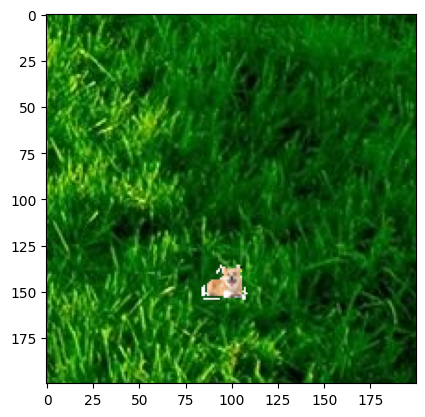

In [42]:
xx = None
yy = None

for x, y in pet_generator():
    xx, yy = x, y
    break

plt.imshow(xx[1])

In [43]:
model = make_model()
model.fit(pet_generator(), steps_per_epoch=5, epochs=5)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 515s 102s/step - loss: 1.8131
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 508s 101s/step - loss: 1.2530
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 501s 100s/step - loss: 1.2147
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 502s 101s/step - loss: 1.0274
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 500s 101s/step - loss: 0.8175


In [45]:
def pet_prediction():
    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape
    rnd_h = np.random.randint(bg_h - AN_DIM)
    rnd_w = np.random.randint(bg_w - AN_DIM)
    x = bg[rnd_h:rnd_h+AN_DIM, rnd_w:rnd_w+AN_DIM].copy()

    appear = (np.random.random() < 0.75)
    if appear:

        pk_idx = np.random.randint(2)
        pk, h, w, _ = pet_data[pk_idx]

        scale = 0.5 + np.random.random()
        new_height = int(h * scale)
        new_width = int(w * scale)
        obj = np.array(pk.resize((new_width, new_height)))

        if np.random.random() < 0.5:
            obj = np.fliplr(obj)

        row0 = np.random.randint(AN_DIM - new_height)
        col0 = np.random.randint(AN_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        mask = (obj[:, :, 3] == 0)
        bg_slice = x[row0:row1, col0:col1, :]
        bg_slice = np.expand_dims(mask, -1) * bg_slice
        bg_slice += obj[:,:,:3]
        x[row0:row1, col0:col1, :] = bg_slice
        actual_class = classnames[pk_idx]
        print(actual_class)

    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    fig, ax = plt.subplots(1)
    ax.imshow(x)

    if p[-1] > 0.5:
        row0 = int(p[0]*AN_DIM)
        col0 = int(p[1]*AN_DIM)
        row1 = int(row0 + p[2]*AN_DIM)
        col1 = int(col0 + p[3]*AN_DIM)
        class_pred_idx = np.argmax(p[4:7])
        class_pred = classnames[class_pred_idx]
        rect = Rectangle((p[1]*AN_DIM, p[0]*AN_DIM), p[3]*AN_DIM, p[2]*AN_DIM,
                     linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        print('No object detected')
    plt.show()

dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


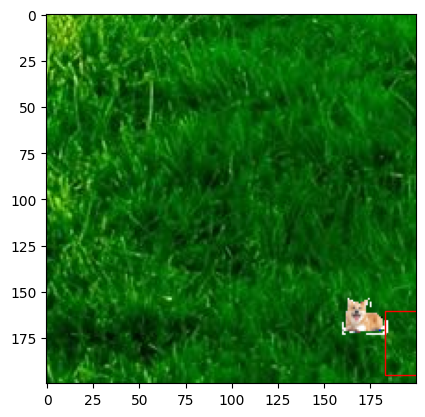

In [65]:
pet_prediction()

In [44]:
model.save('data')